In [28]:
! pip install matplotlib==3.6.1

  Using cached matplotlib-3.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
seaborn 0.13.1 requires matplotlib!=3.6.1,>=3.4, but you have matplotlib 3.6.1 which is incompatible.


In [29]:
! pip install GPy GPyOpt emukit ase scikit-optimize

  Using cached matplotlib-3.3.4-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.1
    Uninstalling matplotlib-3.6.1:
      Successfully uninstalled matplotlib-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
plotnine 0.12.4 requires matplotlib>=3.6.0, but you have matplotlib 3.3.4 which is incompatible.
seaborn 0.13.1 requires matplotlib!=3.6.1,>=3.4, but you have matplotlib 3.3.4 which is incompatible.


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as cp
import random
from sklearn.model_selection import train_test_split

import ase.io
from ase.io import read, write
from ase import Atoms, Atom
from ase import units
from ase.build import molecule
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory

import GPy
import GPyOpt
import emukit
from emukit.core import ContinuousParameter, ParameterSpace, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
# from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.loop import UserFunctionResult
from emukit.core.loop import OuterLoop

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from skopt.space import Real
from sklearn.metrics import mean_squared_error

## Generate Sample Data

In [31]:
from ase.calculators.emt import EMT

def make_water(density, super_cell=[3, 3, 3]):
    """
    Geenrates a supercell of water molecules with a desired density. Density in g/cm^3!!!
    super_cell: list of three integers defining the supercell size in terms of the number
    of unit cells in each direction.

    Process: creates a water molecule, calculates the lattice parameter (a) of the cubic cell
    needed to achieve the desired density.
    Returns a collection of water molecules arranged in this supercell configuration. Each
    water molecule is composed of 3 atmos (2 hydrogens and 1 oxygen), and their positions
    are defined within their respective unit cells.
    """
    h2o = molecule('H2O')
    a = np.cbrt((sum(h2o.get_masses()) * units.m ** 3 * 1E-6 ) / (density * units.mol))
    h2o.set_cell((a, a, a))
    h2o.set_pbc((True, True, True))
    #return cp(h2o.repeat(super_cell))
    return h2o.repeat(super_cell)

calc = EMT()

T = 150  # Kelvin

# Set up a grid of water
water = make_water(1.0, [3, 3, 3])
water.set_calculator(calc)

# We want to run MD using the Langevin algorithm
# with a time step of 1 fs, the temperature T and the friction
# coefficient to 0.002 atomic units.
dyn = Langevin(water, 1 * units.fs, T * units.kB, 0.0002)

def printenergy(a=water):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

dyn.attach(printenergy, interval=5)

# We also want to save the positions of all atoms after every 5th time step.
traj = Trajectory('dyn_emt.traj', 'w', water)
dyn.attach(traj.write, interval=5)

# Now run the dynamics
printenergy(water)
dyn.run(600)   # CHANGE THIS IF YOU WANT LONGER/SHORTER RUN

Energy per atom: Epot = 0.885eV  Ekin = 0.000eV (T=  0K)  Etot = 0.885eV
Energy per atom: Epot = 0.885eV  Ekin = 0.000eV (T=  0K)  Etot = 0.885eV
Energy per atom: Epot = 0.820eV  Ekin = 0.053eV (T=413K)  Etot = 0.874eV
Energy per atom: Epot = 0.660eV  Ekin = 0.208eV (T=1609K)  Etot = 0.868eV
Energy per atom: Epot = 0.632eV  Ekin = 0.224eV (T=1734K)  Etot = 0.857eV
Energy per atom: Epot = 0.869eV  Ekin = 0.005eV (T= 40K)  Etot = 0.874eV
Energy per atom: Epot = 0.781eV  Ekin = 0.088eV (T=682K)  Etot = 0.869eV
Energy per atom: Epot = 0.756eV  Ekin = 0.117eV (T=903K)  Etot = 0.872eV
Energy per atom: Epot = 0.706eV  Ekin = 0.164eV (T=1270K)  Etot = 0.870eV
Energy per atom: Epot = 0.701eV  Ekin = 0.160eV (T=1241K)  Etot = 0.862eV
Energy per atom: Epot = 0.865eV  Ekin = 0.009eV (T= 70K)  Etot = 0.874eV
Energy per atom: Epot = 0.734eV  Ekin = 0.134eV (T=1038K)  Etot = 0.868eV
Energy per atom: Epot = 0.689eV  Ekin = 0.180eV (T=1392K)  Etot = 0.869eV
Energy per atom: Epot = 0.822eV  Ekin = 0.051

True

In [32]:
# wrap and save traj in .xyz --- the .traj is a non human readable database file, xyz is much better
out_traj = ase.io.read('dyn_emt.traj', ':')
for at in out_traj:
    at.wrap()
    if 'momenta' in at.arrays: del at.arrays['momenta']
ase.io.write('dyn_emt.xyz', out_traj, 'xyz')

isolated_H = Atoms('H', calculator=EMT(), cell=[20, 20, 20], pbc=True)
isolated_O = Atoms('O', calculator=EMT(), cell=[20, 20, 20], pbc=True)

print('e0_H:',isolated_H.get_potential_energy())
print('e0_O:',isolated_O.get_potential_energy())

ase.io.write('train.xyz', out_traj[0::2] + [isolated_H] + [isolated_O])
ase.io.write('validate.xyz', out_traj[1::2])

e0_H: 3.21
e0_O: 4.6


In [33]:
# Load the data
# the size of our dataset is 600/5 -> 600 timesteps but we only registered the snapshot's energy every 5 steps

out_traj = read('dyn_emt.xyz', index=':')
print("Number of Samples: ", len(out_traj))

X = []
y = []
for at in out_traj:
    at.set_calculator(calc)
    X.append(at.get_positions().flatten())
    y.append(at.get_potential_energy())

# Shuffle the trajectory indices for a random split
indices = list(range(len(X)))
random.shuffle(indices)

# Split indices for training and validation
split_index = int(len(indices) * 0.8)  # 80-20 split, for example
train_indices = indices[:split_index]
validate_indices = indices[split_index:]

# Include isolated atoms in both datasets
# train_atoms = [out_traj[i] for i in train_indices] + [isolated_H, isolated_O]
X_train, X_val = np.array([X[i] for i in train_indices]), np.array([X[i] for i in validate_indices])
y_train, y_val = np.array([y[i] for i in train_indices]).reshape(-1, 1), np.array([y[i] for i in validate_indices]).reshape(-1, 1)
X_all, y_all = np.array(X), np.array(y).reshape(-1, 1)

Number of Samples:  121


## Set Parameter Space

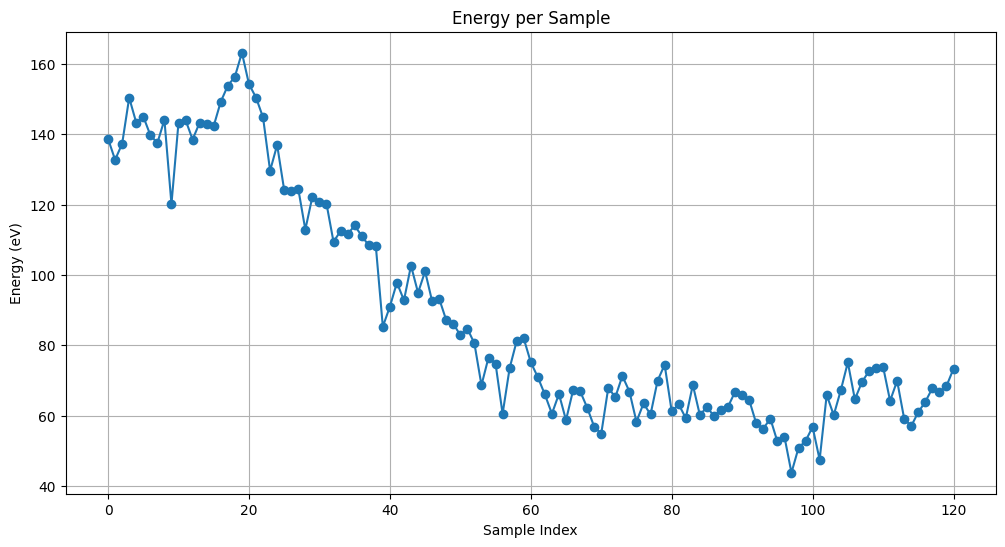

In [34]:
# Number of samples
num_samples = len(y_all)

# Generate a range of sample indices
sample_indices = np.arange(num_samples)

# Plot the energies per sample
plt.figure(figsize=(12, 6))
plt.plot(sample_indices, y_all, marker='o', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel('Energy (eV)')
plt.title('Energy per Sample')
plt.grid(True)
plt.show()

In [35]:
# Number of parameters (in this case, it's the number of coordinates per configuration)
# There are a total of 243 parameters - each sample has 81 atoms, and each atom has 3 coordinates -> 81 * 3 = 243
num_parameters = X_all.shape[1]

# Maximum and minimum values
max_values = X_all.max(axis=0)  # Max value for each parameter across all configurations
min_values = X_all.min(axis=0)  # Min value for each parameter across all configurations

parameters_list = []
for i in range(num_parameters):
    parameter_name = f"param_{i}"
    parameters_list.append(ContinuousParameter(parameter_name, min_values[i], max_values[i]))

# Create continuours parameter space
continuous_parameter_space = ParameterSpace(parameters_list)

## Energy Simulator

In [36]:
def convert_array_to_atoms(array, super_cell=[2, 2, 2]):
    """
    Convert a flattened array of atomic positions into an ASE Atoms object.
    Assumes the array represents a supercell of water molecules.
    """
    if len(array) == 3: # check for the isolated atoms at the end of training dataset
        print("cona")
        array = pad_isolated_atom_data(array)
    reshaped_array = array.reshape(-1, 3)

    # Recreate the Atoms object
    # Assuming each water molecule consists of 'OHH' (Oxygen, Hydrogen, Hydrogen)
    num_molecules = len(reshaped_array) // 3
    symbols = 'OHH' * num_molecules

    # Create the Atoms object
    atoms = Atoms(symbols=symbols, positions=reshaped_array)
    atoms.set_calculator(calc)
    # atoms.set_pbc(True) # comment out after testing
    return atoms

def calculate_energy(X):
    y = []
    for x in X:
        atoms = convert_array_to_atoms(x)
        # print(len(atoms.get_chemical_symbols()))
        y.append(atoms.get_potential_energy())
    return np.array(y).reshape(-1, 1)

In [37]:
def get_isolated_H_data():
    positions = isolated_H.get_positions().flatten()
    energy = isolated_H.get_potential_energy()
    return positions, energy

def get_isolated_O_data():
    positions = isolated_O.get_positions().flatten()
    energy = isolated_O.get_potential_energy()
    return positions, energy

# Function to pad isolated atom data to match the size of other samples
def pad_isolated_atom_data(atom_positions, total_size=243):
    # Flatten the positions and pad with zeros to match the required size
    padded_positions = np.zeros(total_size)
    padded_positions[:len(atom_positions)] = atom_positions.flatten()
    return padded_positions

## Plotting

In [38]:
def rms_dict(x_ref, x_pred):
    """ Takes two datasets of the same shape and returns a dictionary containing RMS error data"""

    x_ref = np.array(x_ref)
    x_pred = np.array(x_pred)
    print(x_ref.shape)
    print(x_pred.shape)

    if np.shape(x_pred) != np.shape(x_ref):
        raise ValueError('WARNING: not matching shapes in rms')

    error_2 = (x_ref - x_pred) ** 2

    average = np.sqrt(np.average(error_2))
    std_ = np.sqrt(np.var(error_2))

    return {'rmse': average, 'std': std_}


In [39]:
def energy_plot(true_energy, predicted_energy, ax, title='Plot of energy'):
    """ Plots the distribution of energy per atom on the output vs the input"""
    # list energies
    ener_in = [at_energy / 81 for at_energy in true_energy]
    ener_out = [at_energy/ 81 for at_energy in predicted_energy]
    # print(ener_in.shape)
    # print(ener_out.shape)
    # scatter plot of the data
    ax.scatter(ener_in, ener_out)
    # get the appropriate limits for the plot
    for_limits = np.array(ener_in +ener_out)
    elim = (for_limits.min() - 0.05, for_limits.max() + 0.05)
    ax.set_xlim(elim)
    ax.set_ylim(elim)
    # add line of slope 1 for refrence
    ax.plot(elim, elim, c='k')
    # set labels
    ax.set_ylabel('energy by GAP / eV')
    ax.set_xlabel('energy by EMT / eV')
    #set title
    ax.set_title(title)
    # add text about RMSE
    _rms = rms_dict(ener_in, ener_out)
    rmse_text = 'RMSE:\n' + str(np.round(_rms['rmse'], 3)) + ' +- ' + str(np.round(_rms['std'], 3)) + 'eV/atom'
    ax.text(0.9, 0.1, rmse_text, transform=ax.transAxes, fontsize='large', horizontalalignment='right',
            verticalalignment='bottom')

## GP Model (Grant's version)

In [40]:
! pip install scikit-optimize

In [41]:
print("Size of training dataset: ", len(X_train))
print("\n Number of parameters per sample (data point): ", len(X_train[0]))
print("\n Number of atoms in training dataset: ", len(X_train[0])//3)
print("\nTraining data (y) stats:", "min:", np.min(y_train), "max:", np.max(y_train), "mean:", np.mean(y_train), "variance:", np.var(y_train))

# Check if my implementation to create Atoms objects from an array of coordinates works
# We compare the energy extracted from the original Atoms objects againts the energy
# extracted from our Atoms objects built from an array of coordinates (X_train)

y_train_2 = calculate_energy(X_train)
# y_train_2 = np.array(y_train_2).reshape(-1, 1)
result = (y_train == y_train_2).all()

"""
If we try using get_potential_energy() on the full dataset (out_traj) and on the training dataset,
the energies from the training one do not appear in the full dataset. It has something to do to
how the dataset is split and it affects the atoms object. We would expect that the extracted
energies from the atoms in the training dataset should match the ones from the full dataset
(every other position since training was split as the even index positions of the full dataset).
Atoms object from full dataset: Atoms(symbols='H54O27', pbc=False, calculator=EMT(...))
Atoms object from training (and val) dataset: Atoms(symbols='H54O27', pbc=True,
cell=[9.312844978309194, 9.312844978309194, 9.312844978309194], energies=..., forces=...,
calculator=SinglePointCalculator(...))
"""
# Yes, if we train GP on full dataset. No, if we train it on the training dataset.
print("\nDoes y_train matches y_train_2 for all elements? ", result)

Size of training dataset:  96

 Number of parameters per sample (data point):  243

 Number of atoms in training dataset:  81

Training data (y) stats: min: 47.46331409296971 max: 163.20588457807946 mean: 89.34055011834874 variance: 1061.9052312469876

Does y_train matches y_train_2 for all elements?  True


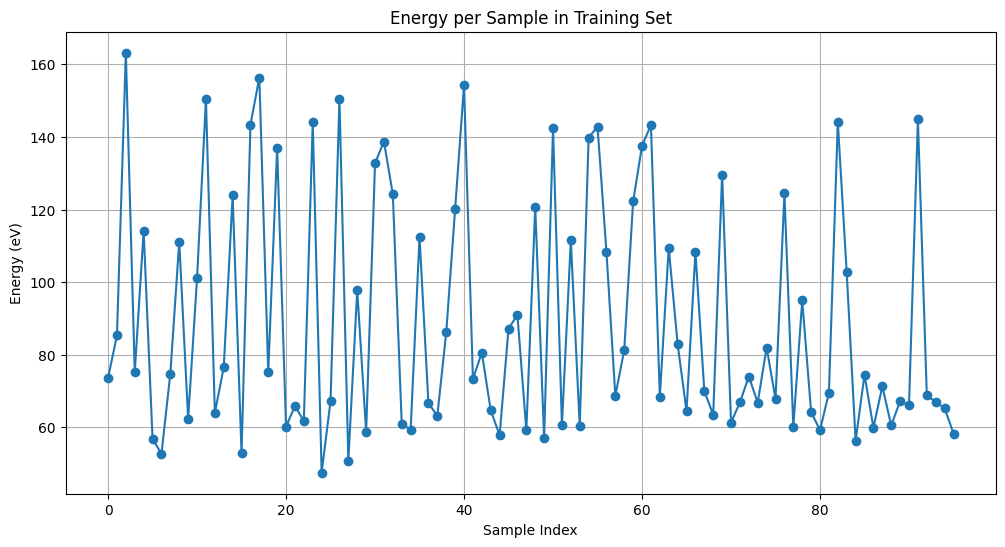

In [42]:
# Number of samples
num_samples = len(y_train)

# Generate a range of sample indices
sample_indices = np.arange(num_samples)

# Plot the energies per sample
plt.figure(figsize=(12, 6))
plt.plot(sample_indices, y_train, marker='o', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel('Energy (eV)')
plt.title('Energy per Sample in Training Set')
plt.grid(True)
plt.show()

In [43]:
kernel_energy = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=0.01)

# Train the Gaussian Process for energy prediction
gp_energy = GaussianProcessRegressor(kernel=kernel_energy)
gp_energy.fit(X_train, y_train)

# # Define the kernels
# constant_kernel = GPy.kern.Bias(1, variance=1.0)  # Equivalent to ConstantKernel
# rbf_kernel = GPy.kern.RBF(input_dim=1, variance=10, lengthscale=1.0)  # RBF kernel
# white_kernel = GPy.kern.White(1, variance=0.01)  # Equivalent to WhiteKernel

# # Combine the kernels
# combined_kernel = constant_kernel + rbf_kernel + white_kernel

# print(X_train.shape)
# model_gpy = GPRegression(X_train, y_train, kernel=combined_kernel) # Train and wrap the model in Emukit
# model_gpy.optimize()
# model_emukit = GPyModelWrapper(model_gpy)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10) + WhiteKernel(noise_level=0.01))

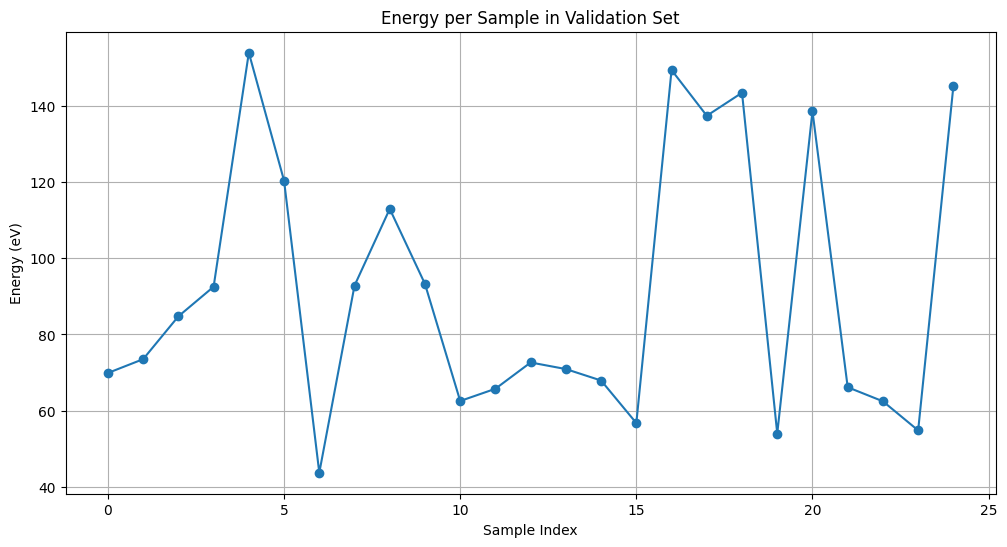

In [44]:
# Number of samples
num_samples = len(y_val)

# Generate a range of sample indices
sample_indices = np.arange(num_samples)

# Plot the energies per sample
plt.figure(figsize=(12, 6))
plt.plot(sample_indices, y_val, marker='o', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel('Energy (eV)')
plt.title('Energy per Sample in Validation Set')
plt.grid(True)
plt.show()

Predicted values (first 10): [[ 65.59864532]
 [ 73.4308707 ]
 [ 81.83019435]
 [ 94.08461456]
 [161.08979967]
 [118.37559053]
 [ 50.45496797]
 [ 99.1145196 ]
 [124.8228844 ]
 [ 89.00658101]]
Predicted variances (first 10): [8.11143492 8.04367571 7.29419858 7.47508973 6.65844892 7.02960581
 5.96807779 5.90689028 7.70195052 7.30351036]


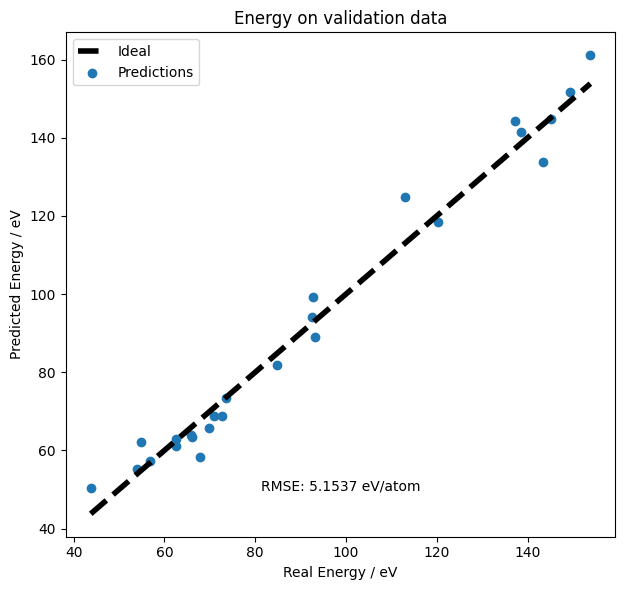

In [45]:
# Predict energies on the validation set
y_pred, y_var = gp_energy.predict(X_val, return_std=True)
y_pred = np.array(y_pred).reshape(-1, 1)
# y_pred, y_var = model_emukit.predict(X_val)
print("Predicted values (first 10):", y_pred[:10])
print("Predicted variances (first 10):", y_var[:10])

# RMSE calculation - assuming y_val and y_pred are numpy arrays
rmse = np.sqrt(((y_val - y_pred)**2).mean())

# Create the plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred, label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4, label='Ideal')
plt.xlabel('Real Energy / eV')
plt.ylabel('Predicted Energy / eV')
plt.title('Energy on validation data')
plt.legend()
plt.text(0.5, 0.1, f'RMSE: {rmse:.4f} eV/atom', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# You can add a similar plot for the training data on the same figure (plt.subplot(1, 2, 2)) if desired

plt.tight_layout()
plt.show()


(96, 1)
(96, 1)
(25, 1)
(25, 1)


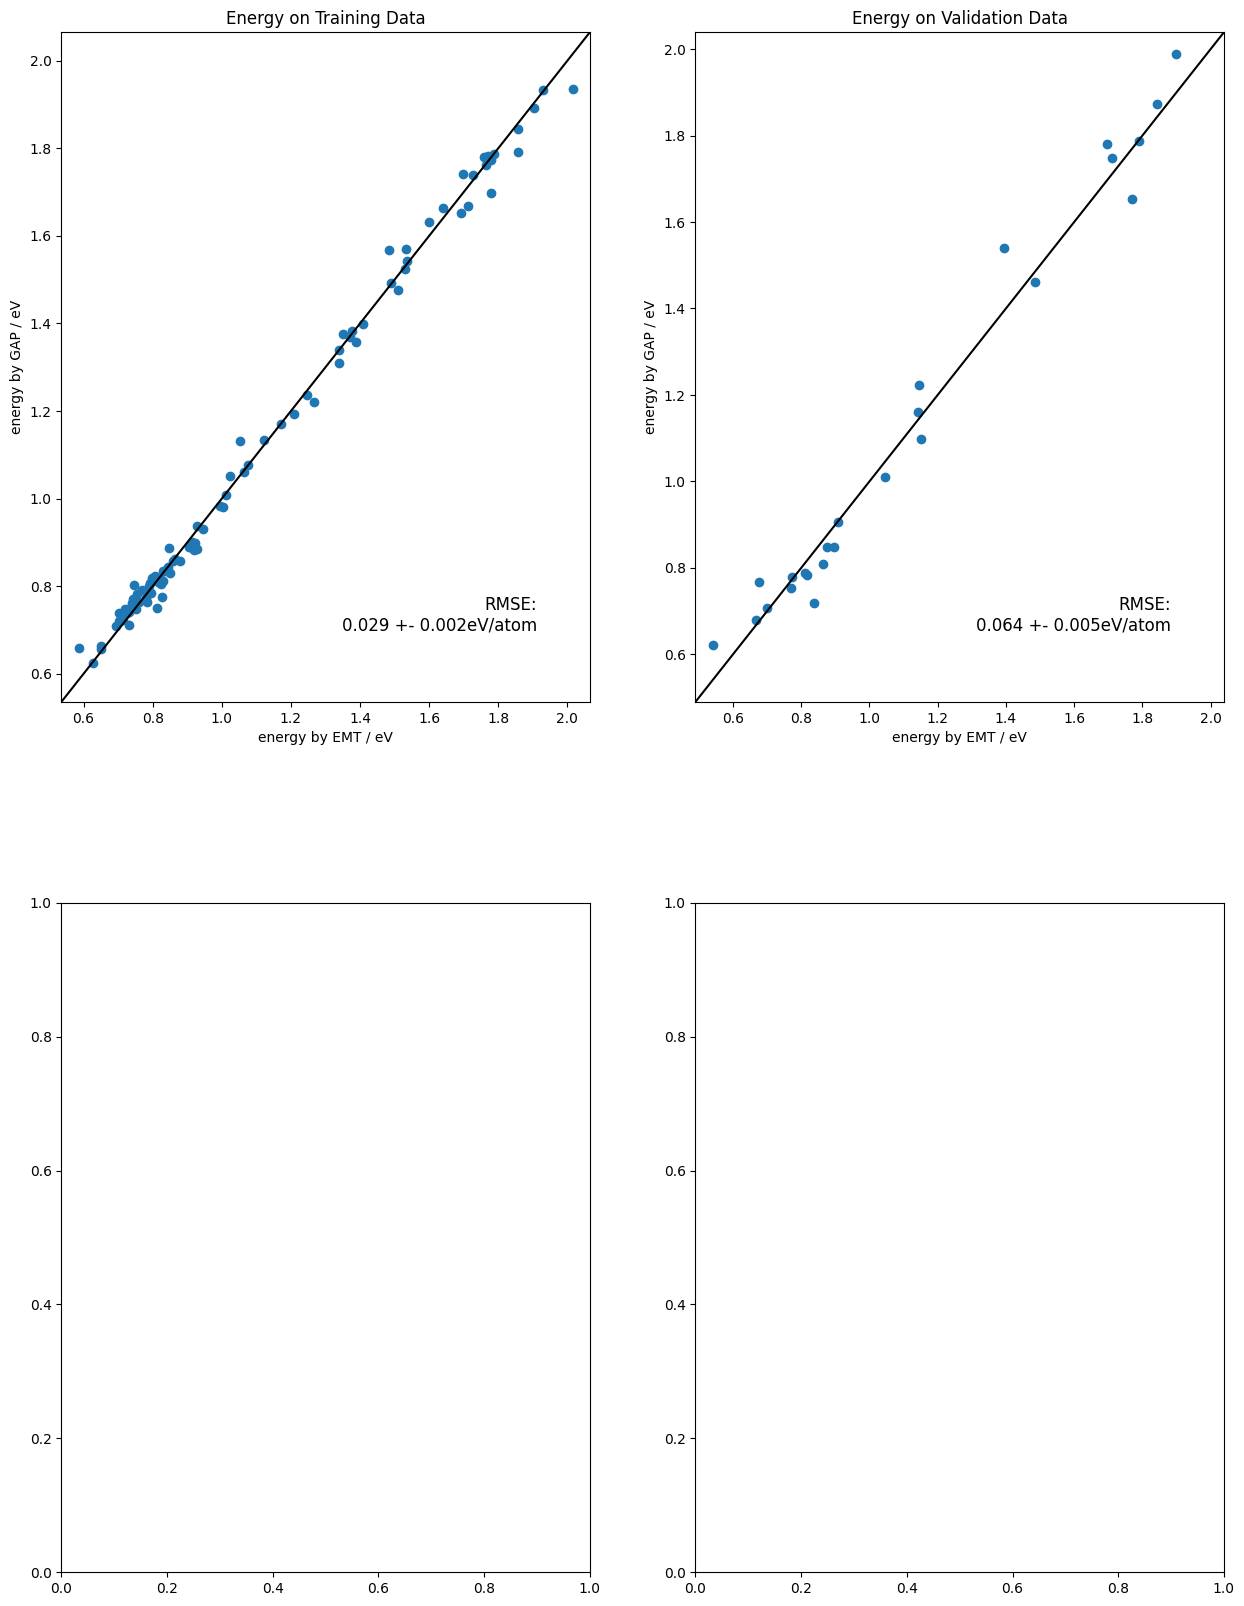

In [46]:
fig, ax_list = plt.subplots(nrows=2, ncols=2, gridspec_kw={'hspace': 0.3})
fig.set_size_inches(15, 20)
ax_list = ax_list.flat[:]

y_train_pred, y_var = gp_energy.predict(X_train, return_std=True)
y_train_pred = np.array(y_train_pred).reshape(-1, 1)

energy_plot(y_train, y_train_pred, ax_list[0], 'Energy on Training Data')
energy_plot(y_val, y_pred, ax_list[1], 'Energy on Validation Data')

## GP Model

In [ ]:
design = LatinDesign(continuous_parameter_space) # Collect random points
num_training_points = 96
X = design.get_samples(num_training_points)

# Calculate statistics for each parameter
min_vals = X.min(axis=0)
max_vals = X.max(axis=0)
mean_vals = X.mean(axis=0)
std_dev_vals = X.std(axis=0)

# Print the statistics
print("\nStatistics for each parameter:")
for i in range(X.shape[1]):
    print(f"Parameter {i}: Min = {min_vals[i]:.4f}, Max = {max_vals[i]:.4f}, Mean = {mean_vals[i]:.4f}, Std Dev = {std_dev_vals[i]:.4f}")

# Add the isolated atoms' data to your training set
isolated_H_positions, isolated_H_energy = get_isolated_H_data()
isolated_O_positions, isolated_O_energy = get_isolated_O_data()

# Pad the data
padded_H_positions = pad_isolated_atom_data(isolated_H_positions)
padded_O_positions = pad_isolated_atom_data(isolated_O_positions)

# Append isolated atoms data to X
# Note: You might need to reshape or adjust the format to match your existing data structure
# X = np.vstack([X_train, padded_H_positions, padded_O_positions])

y = calculate_energy(X)
# y[-2], y[-1] = isolated_H_energy, isolated_O_energy

print("Training data (y) stats:", "min:", np.min(y), "max:", np.max(y), "mean:", np.mean(y), "variance:", np.var(y))


Statistics for each parameter:
Parameter 0: Min = 0.0485, Max = 9.2643, Mean = 4.6564, Std Dev = 2.6882
Parameter 1: Min = 0.0485, Max = 9.2638, Mean = 4.6561, Std Dev = 2.6881
Parameter 2: Min = 0.0598, Max = 9.2610, Mean = 4.6604, Std Dev = 2.6840
Parameter 3: Min = 0.0482, Max = 9.2152, Mean = 4.6317, Std Dev = 2.6740
Parameter 4: Min = 0.1241, Max = 9.1870, Mean = 4.6556, Std Dev = 2.6436
Parameter 5: Min = 0.0687, Max = 9.1526, Mean = 4.6107, Std Dev = 2.6498
Parameter 6: Min = 0.0485, Max = 9.2639, Mean = 4.6562, Std Dev = 2.6881
Parameter 7: Min = 0.0664, Max = 9.1789, Mean = 4.6227, Std Dev = 2.6581
Parameter 8: Min = 0.0563, Max = 9.2604, Mean = 4.6584, Std Dev = 2.6848
Parameter 9: Min = 0.0485, Max = 9.2641, Mean = 4.6563, Std Dev = 2.6882
Parameter 10: Min = 0.0485, Max = 9.2639, Mean = 4.6562, Std Dev = 2.6881
Parameter 11: Min = 0.1395, Max = 9.2206, Mean = 4.6800, Std Dev = 2.6490
Parameter 12: Min = 0.0485, Max = 9.2639, Mean = 4.6562, Std Dev = 2.6881
Parameter 13: Mi

96


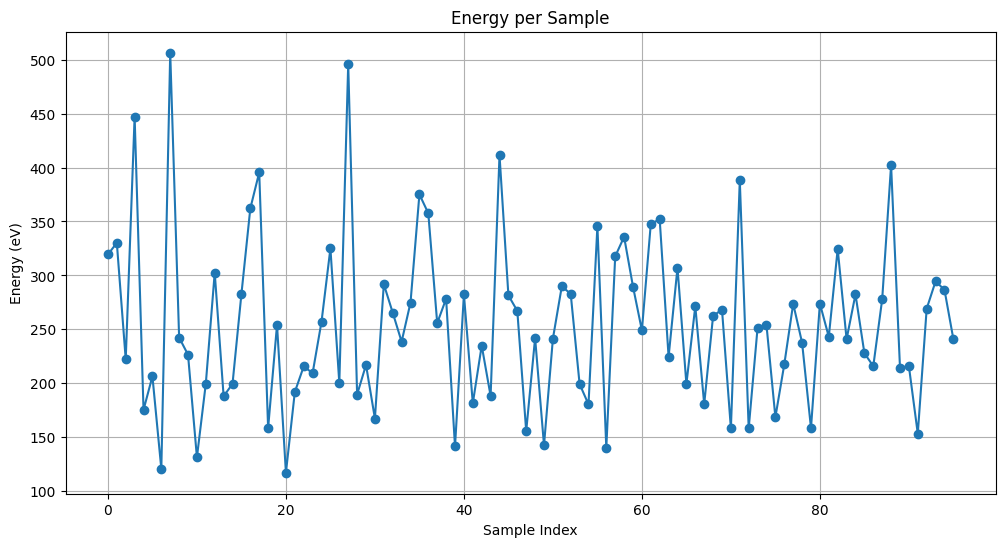

In [ ]:
# Number of samples
num_samples = len(y)
print(num_samples)

# Generate a range of sample indices
sample_indices = np.arange(num_samples)

# Plot the energies per sample
plt.figure(figsize=(12, 6))
plt.plot(sample_indices, y, marker='o', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel('Energy (eV)')
plt.title('Energy per Sample')
plt.grid(True)
plt.show()

In [ ]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

# Define the kernels
constant_kernel = GPy.kern.Bias(1, variance=1.0)  # Equivalent to ConstantKernel
rbf_kernel = GPy.kern.RBF(input_dim=1, variance=10, lengthscale=1.0)  # RBF kernel
white_kernel = GPy.kern.White(1, variance=0.01)  # Equivalent to WhiteKernel

# Combine the kernels
combined_kernel = constant_kernel + rbf_kernel + white_kernel

model_gpy = GPRegression(X, y, kernel=combined_kernel) # Train and wrap the model in Emukit
model_emukit = GPyModelWrapper(model_gpy)

In [ ]:
from emukit.experimental_design.acquisitions import ModelVariance

model_variance = ModelVariance(model = model_emukit)

In [ ]:
from emukit.experimental_design import ExperimentalDesignLoop

expdesign_loop = ExperimentalDesignLoop(model = model_emukit,
                                         space = continuous_parameter_space,
                                         acquisition = model_variance,
                                         batch_size = 5)

In [ ]:
max_iterations = 15
expdesign_loop.run_loop(calculate_energy, max_iterations)

In [ ]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=0.01)

# Train the Gaussian Process for energy prediction
gp_energy_2 = GaussianProcessRegressor(kernel=kernel)
# Flatten the y_energy_train list before fitting
gp_energy_2.fit(X, y)

# # Define the kernels
# constant_kernel = GPy.kern.Bias(1, variance=1.0)  # Equivalent to ConstantKernel
# rbf_kernel = GPy.kern.RBF(input_dim=1, variance=10, lengthscale=1.0)  # RBF kernel
# white_kernel = GPy.kern.White(1, variance=0.01)  # Equivalent to WhiteKernel

# # Combine the kernels
# combined_kernel = constant_kernel + rbf_kernel + white_kernel

# model_gpy = GPRegression(X, y, kernel=combined_kernel) # Train and wrap the model in Emukit
# model_gpy.optimize()
# model_emukit = GPyModelWrapper(model_gpy)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10) + WhiteKernel(noise_level=0.01))

In [ ]:
num_val_points = 20
# X_val = design.get_samples(num_val_points)
y_val = calculate_energy(X_val)

[[266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]]
Predicted values (first 10): [[266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]
 [266.22022459]]
Predicted variances (first 10): [[7903.87755314]
 [7903.87755314]
 [7903.87755314]
 [7903.87755314]
 [7903.87755314]
 [7903.87755314]
 [7903.87755314]
 [7903.87755314]
 [7903.87755314]
 [7903.87755314]]


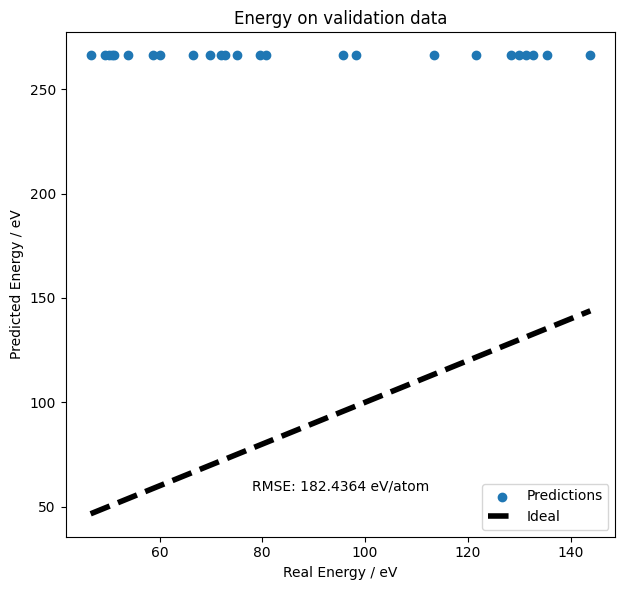

In [ ]:
# Predict energies on the validation set
# y_pred, y_var = gp_energy_2.predict(X_val, return_std=True)
y_pred, y_var = model_emukit.predict(X_val)
print(y_pred)
print("Predicted values (first 10):", y_pred[:10])
print("Predicted variances (first 10):", y_var[:10])

# RMSE calculation - assuming y_val and y_pred are numpy arrays
rmse = np.sqrt(((y_val - y_pred)**2).mean())

# Create the plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred, label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4, label='Ideal')
plt.xlabel('Real Energy / eV')
plt.ylabel('Predicted Energy / eV')
plt.title('Energy on validation data')
plt.legend()
plt.text(0.5, 0.1, f'RMSE: {rmse:.4f} eV/atom', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# You can add a similar plot for the training data on the same figure (plt.subplot(1, 2, 2)) if desired

plt.tight_layout()
plt.show()

## Bayesian Optimization

In [47]:
def print_energy_callback(loop, loop_state):
    """
    A callback function to print the energy level after each iteration.
    """
    iteration = len(loop_state.Y)
    latest_result = loop_state.Y[-1][0]  # Assuming Y is a 2D array with shape (n_samples, 1)
    print(f"Iteration {iteration}: Energy = {latest_result}")

In [48]:
from emukit.core.interfaces import IModel

class SklearnGPModel(IModel):
    def __init__(self, sklearn_model, X_init, Y_init):
        self.model = sklearn_model
        self.X_data = X_init
        self.Y_data = Y_init
        self.model.fit(X_init, Y_init)

    def predict(self, X):
        mean, std = self.model.predict(X, return_std=True)
        return mean[:, None], np.square(std)[:, None]

    def set_data(self, X: np.ndarray, Y: np.ndarray) -> None:
        self.X_data = X
        self.Y_data = Y
        self.model.fit(X, Y)

    def optimize(self, verbose: bool = False) -> None:
        # There is no separate optimization routine for sklearn models
        pass

    @property
    def X(self) -> np.ndarray:
        return self.X_data

    @property
    def Y(self) -> np.ndarray:
        return self.Y_data


In [21]:
from emukit.experimental_design.acquisitions import ModelVariance

model_variance = ModelVariance(model = model_emukit)

NameError: name 'model_emukit' is not defined

In [ ]:
from emukit.experimental_design import ExperimentalDesignLoop

expdesign_loop = ExperimentalDesignLoop(model = model_emukit,
                                         space = continuous_parameter_space,
                                         acquisition = model_variance,
                                         batch_size = 5)

In [ ]:
max_iterations = 20
expdesign_loop.run_loop(calculate_energy, max_iterations)

In [ ]:
fig, ax_list = plt.subplots(nrows=2, ncols=2, gridspec_kw={'hspace': 0.3})
fig.set_size_inches(15, 20)
ax_list = ax_list.flat[:]

y_train_pred, y_var = expdesign_loop.model.predict(X_train)
y_train_pred = np.array(y_train_pred).reshape(-1, 1)

y_pred, y_var = expdesign_loop.model.predict(X_val)
y_pred = np.array(y_pred).reshape(-1, 1)

y_val = calculate_energy(X_val)

energy_plot(y_train, y_train_pred, ax_list[0], 'Energy on Training Data')
energy_plot(y_val, y_pred, ax_list[1], 'Energy on Validation Data')

In [50]:
from scipy.spatial.distance import cdist

def find_nearest_dataset_point(x_new, X_dataset):
    distaces = cdist(X_dataset, x_new)
    nearest_index = np.argmin(distaces)
    return X_dataset[nearest_index]

def bo(X_all, optimizer):
    # Initialize your dataset and GP model
    index = np.random.permutation(len(X_all))
    X_init = X_all[index[:5]]
    Y_init = calculate_energy(X_init)
    X_remaining = np.delete(X_all, index[:5], axis=0)

    kernel_energy = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=0.01)
    gp = GaussianProcessRegressor(kernel=kernel_energy)

    # Wrap the model with Emukit
    model_emukit = SklearnGPModel(gp, X_init, Y_init)

    # Define the acquisition function
    acquisition = ExpectedImprovement(model_emukit)

    # Bayesian optimization loop
    bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                            space=continuous_parameter_space,
                                            acquisition=acquisition,
                                            acquisition_optimizer=optimizer)

    # Running the loop
    best_value = np.min(Y_init)  # Initialize best value
    optimal_value = np.min(calculate_energy(X_all))
    print("Optimal Min: ", optimal_value)

    regrets = []
    observed_energies = [best_value]

    for iter_num in range(20):
        x_next = bayesopt_loop.candidate_point_calculator.compute_next_points(bayesopt_loop.loop_state)
        x_nearest = find_nearest_dataset_point(x_next, X_remaining)
        x_nearest = x_nearest.reshape(1, -1)

        y_nearest = calculate_energy(x_nearest)
        print("Current besy: ", best_value)
        print("Step: ", y_nearest)
        if y_nearest < best_value:
            best_value = y_nearest

        current_regret = best_value - optimal_value
        regrets.append(current_regret)

        model_emukit.set_data(np.vstack((model_emukit.X, x_nearest)), np.vstack((model_emukit.Y, y_nearest.reshape(-1, 1))))
        model_emukit.optimize()

        X_remaining = np.delete(X_remaining, np.argwhere(np.all(X_remaining==x_nearest, axis=1)), axis=0)

        # Update observed energies
        observed_energies.append(np.min(model_emukit.Y))

    f_min = np.min(model_emukit.Y)
    x_min = model_emukit.X[np.argmin(model_emukit.Y)]

    return f_min, regrets, observed_energies

In [51]:
def plot_bo(regrets, observed_energies):

    # Reshape or squeeze the regrets to be 1D if necessary
    if np.array(regrets).ndim > 1:
        regrets_array = np.array(regrets).squeeze()
    else:
        # Convert regrets to a NumPy array for easier handling
        regrets_array = np.array(regrets).flatten()

    plt.figure(figsize=(12, 6))

    # Define the step for the x-axis ticks
    tick_step = 2

    # First subplot for observed energies
    plt.subplot(1, 2, 1)
    plt.plot(range(len(observed_energies)), observed_energies, marker='o')
    plt.title("Observed Energies per Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.xticks(range(0, len(observed_energies), tick_step))  # Set x-axis ticks with a step

    # Second subplot for regrets
    plt.subplot(1, 2, 2)
    plt.plot(range(len(regrets_array)), regrets_array, marker='o', color='red')
    plt.title("Regrets over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Regret")
    plt.xticks(range(0, len(regrets_array), tick_step))  # Set x-axis ticks with a step

    plt.tight_layout()
    plt.show()

In [62]:
# f = calculate_energy(X=X_train)
# max_iterations = 20
# acquired = []
# # bayesopt_loop.run_loop(f, max_iterations)
# for _ in range(max_iterations):
#     x_next = bayesopt_loop.candidate_point_calculator.compute_next_points(bayesopt_loop.loop_state)
#     x_nearest = find_nearest_dataset_point(x_next, X_train)
#     # y_nearest = get_energies(x_nearest)
#     x_nearest = x_nearest.reshape(1, -1)
#     acquired.append(x_nearest)
#     y_nearest, _ = model_emukit.predict(x_nearest)

#     model_emukit.set_data(np.vstack((model_emukit.X, x_nearest)), np.vstack((model_emukit.Y, y_nearest)))  # Update model with the nearest point
#     model_emukit.optimize()  # Re-optimize the model


from emukit.core.optimization import GradientAcquisitionOptimizer, LocalSearchAcquisitionOptimizer, MultiSourceAcquisitionOptimizer
from emukit.core.optimization.optimizer import Optimizer
from emukit.core.optimization.random_search_acquisition_optimizer import RandomSearchAcquisitionOptimizer

optimizers = [GradientAcquisitionOptimizer(continuous_parameter_space),
            LocalSearchAcquisitionOptimizer(continuous_parameter_space),
            RandomSearchAcquisitionOptimizer(continuous_parameter_space)]

all_regrets = [[] for _ in optimizers]
all_observed_energies = [[] for _ in optimizers]

np.random.seed(42)

# Run Bayesian Optimization for each optimizer
for i, optimizer in enumerate(optimizers):
    print(f"\nRunning BO with optimizer: {type(optimizer).__name__}")
    f_min, regrets, observed_energies = bo(X_all, optimizer)

    # Store the results
    all_regrets[i].append(regrets)
    all_observed_energies[i].append(observed_energies)

    print("Found min ", f_min, "for optimizer ", type(optimizer).__name__)



Running BO with optimizer: GradientAcquisitionOptimizer
Optimal Min:  43.76479926396576
Current besy:  74.78999358209302
Step:  [[57.79932914]]
Current besy:  [[57.79932914]]
Step:  [[65.87754905]]
Current besy:  [[57.79932914]]
Step:  [[63.92562692]]
Current besy:  [[57.79932914]]
Step:  [[61.2481123]]
Current besy:  [[57.79932914]]
Step:  [[68.4077282]]
Current besy:  [[57.79932914]]
Step:  [[59.29350249]]
Current besy:  [[57.79932914]]
Step:  [[68.7539979]]
Current besy:  [[57.79932914]]
Step:  [[52.64954883]]
Current besy:  [[52.64954883]]
Step:  [[59.17756619]]
Current besy:  [[52.64954883]]
Step:  [[75.12904054]]
Current besy:  [[52.64954883]]
Step:  [[54.03246345]]
Current besy:  [[52.64954883]]
Step:  [[65.76899997]]
Current besy:  [[52.64954883]]
Step:  [[43.76479926]]
Current besy:  [[43.76479926]]
Step:  [[50.8214843]]
Current besy:  [[43.76479926]]
Step:  [[74.46609023]]
Current besy:  [[43.76479926]]
Step:  [[52.79135576]]
Current besy:  [[43.76479926]]
Step:  [[56.776520

In [53]:
from scipy.stats import norm
def expected_improvement(f_star, mu, varSigma, X):
    alpha = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        sigma = np.sqrt(varSigma[i])  # Standard deviation at point i
        mu_i = mu[i]  # Mean prediction at point i
        diff = f_star - mu_i

        # Check if sigma is very close to zero (to avoid division by zero)
        if sigma > 1e-10:
            Z = diff / sigma
            alpha[i] = diff * norm.cdf(Z) + sigma * norm.pdf(Z)
        else:
            alpha[i] = 0  # If sigma is zero, EI is zero

    return alpha

In [63]:
index = np.random.permutation(len(X_all))
X_init = X_all[index[0:5]]
Y_init = calculate_energy(X_init)

X_remaining = np.delete(X_all, index[0:5], axis=0)

X = X_init
Y = Y_init

kernel_energy = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=0.01)
gp = GaussianProcessRegressor(kernel=kernel_energy)

iter_num = 0
best_value = [[np.min(Y)]] # initialise best value
optimal_value = np.min(calculate_energy(X_all))
print("Optimal Min: ", optimal_value)
regrets = []

while iter_num < 20:
    gp.fit(X, Y)
    mu, varSigma = gp.predict(X_remaining, return_std=True)

    alpha = expected_improvement(best_value, mu, varSigma, X_remaining)

    x_new_idx = np.argmax(alpha)
    x_new = X_remaining[x_new_idx].reshape(1, -1)
    y_new = calculate_energy(x_new)

    if y_new < best_value:
        best_value = y_new

    current_regret = best_value - optimal_value
    regrets.append(current_regret)

    X = np.vstack((X, x_new))
    Y = np.vstack((Y, y_new))

    X_remaining = np.delete(X_remaining, x_new_idx, axis=0)

    iter_num +=1

all_observed_energies.append(Y)
all_regrets.append(regrets)

f_min = np.min(Y)
x_min = X[np.argmin(Y)]
print("Found Min: ", f_min)

Optimal Min:  43.76479926396576
Found Min:  52.64954882586995


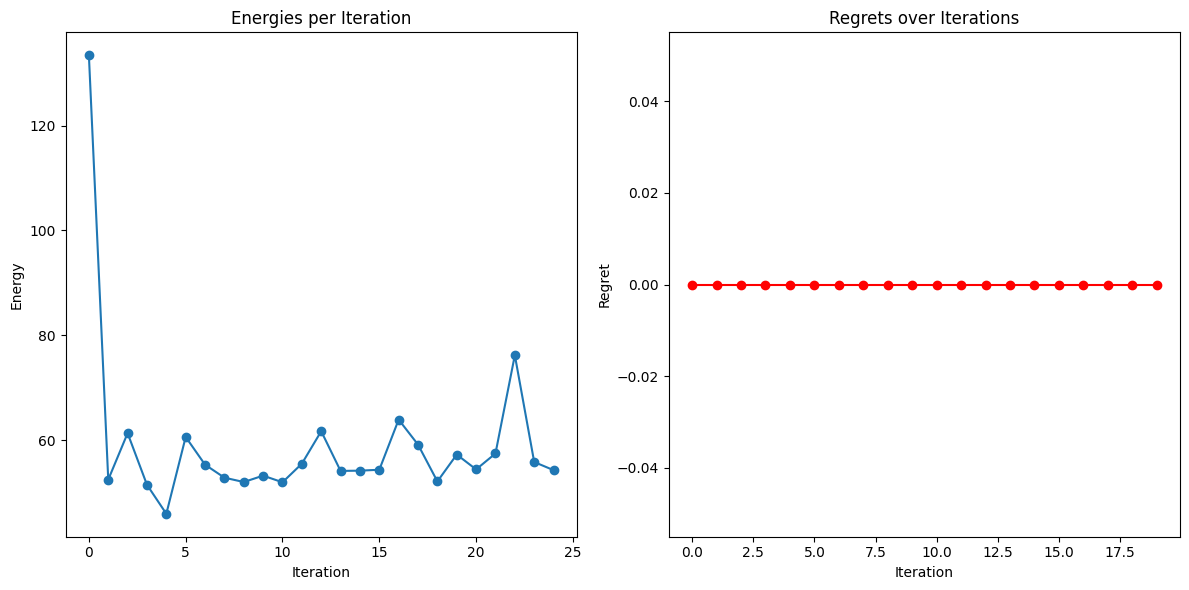

In [27]:
# Convert regrets to a NumPy array for easier handling
regrets_array = np.array(regrets).flatten()

# Energies per iteration
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(Y)), np.min(Y, axis=1), marker='o')
plt.title("Energies per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Energy")

# Regrets plot
plt.subplot(1, 2, 2)
plt.plot(range(len(regrets_array)), regrets_array, marker='o', color='red')
plt.title("Regrets over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Regret")

plt.tight_layout()
plt.show()

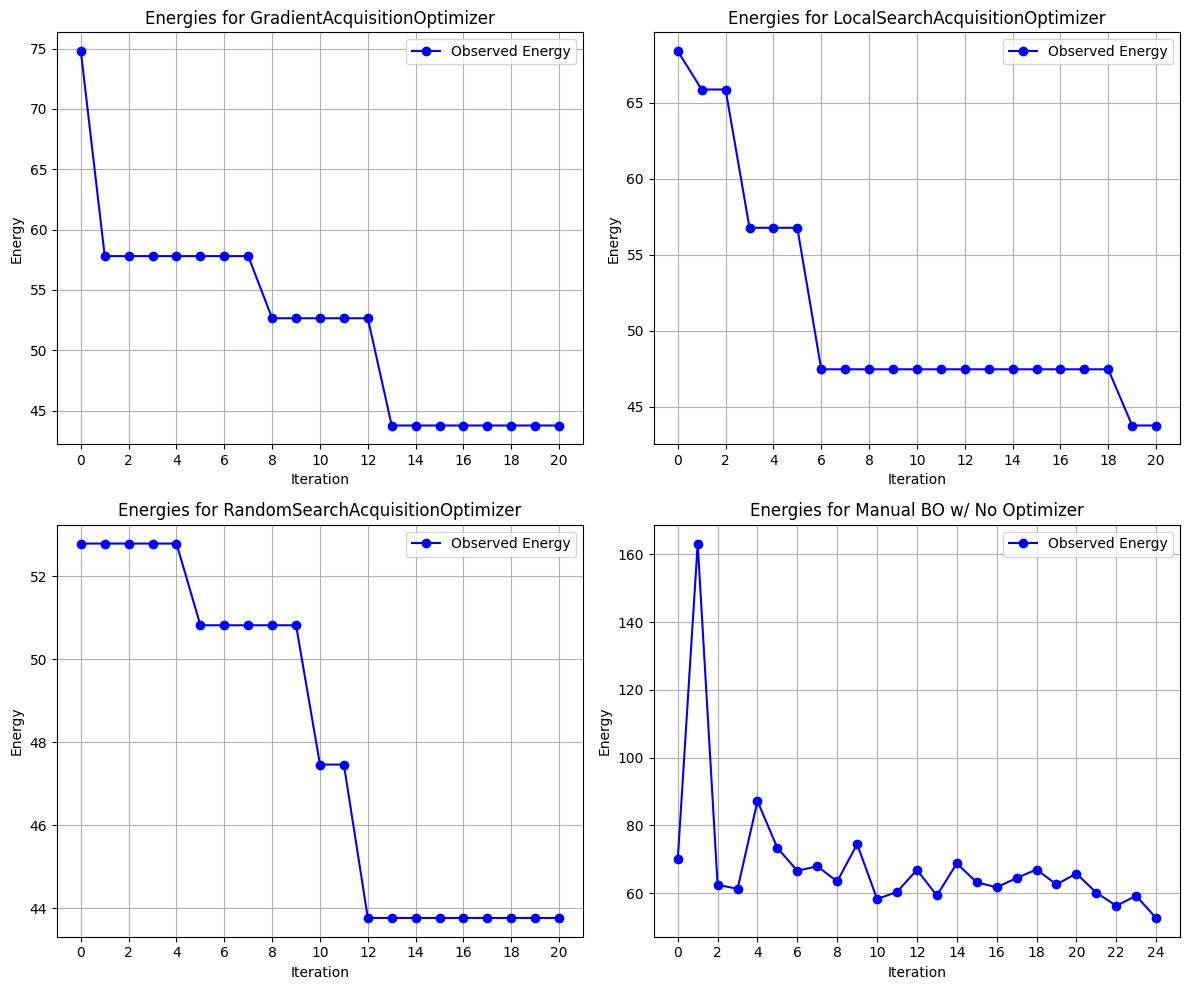

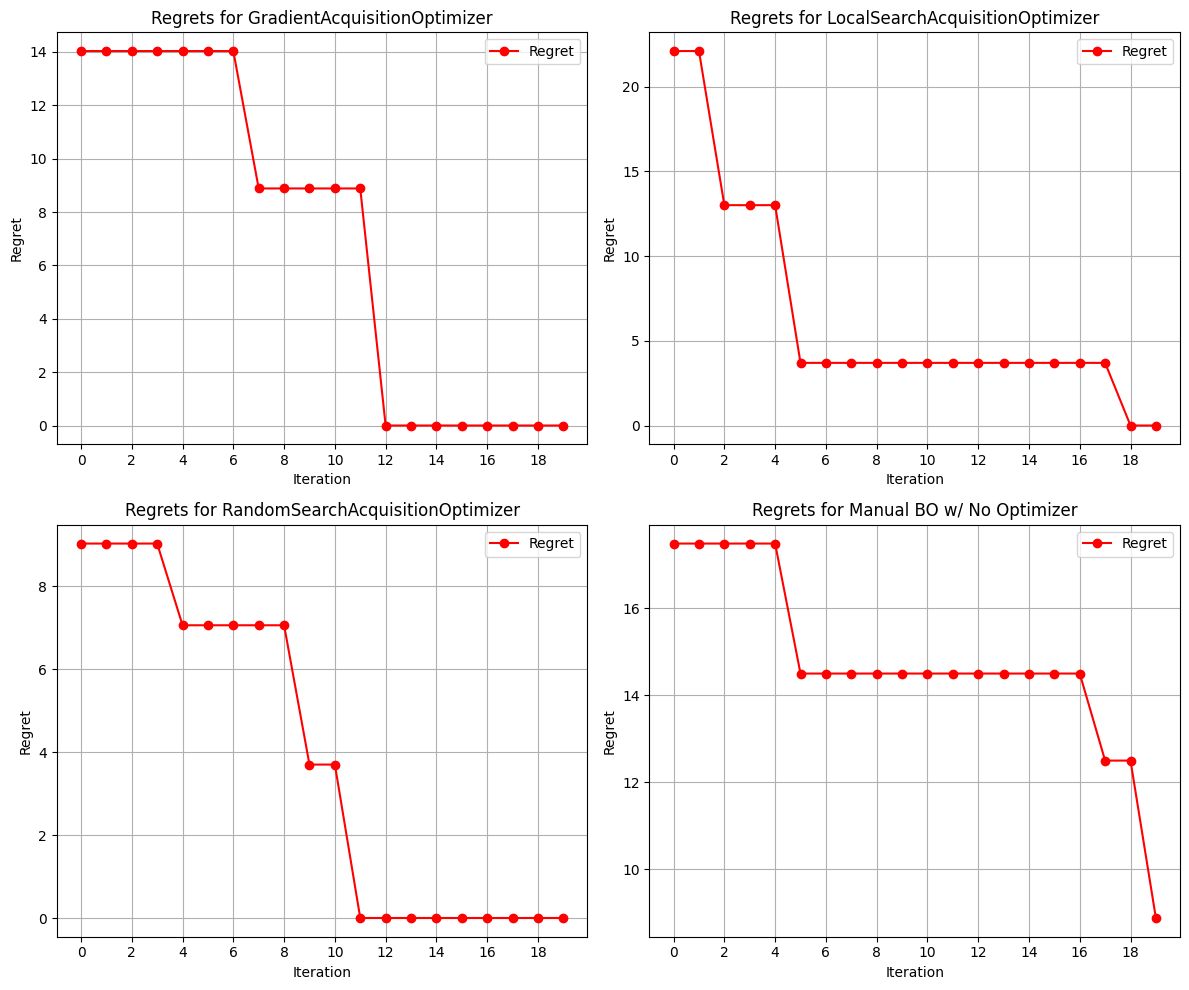

In [65]:

def plot_bo_grid(data_list, title_prefix, ylabel):
    nrows, ncols = 2, 2  # Grid layout
    plt.figure(figsize=(12, 10))

    for i, data in enumerate(data_list):

        if i==0:
            optimizer = "GradientAcquisitionOptimizer"
        elif i==1:
            optimizer = "LocalSearchAcquisitionOptimizer"
        elif i==2:
            optimizer = "RandomSearchAcquisitionOptimizer"
        else:
            optimizer = "Manual BO w/ No Optimizer"

        # Reshape or squeeze the data to be 1D if necessary
        if np.array(data).ndim > 1:
            data_array = np.array(data).squeeze()
        else:
            data_array = np.array(data).flatten()

        ax = plt.subplot(nrows, ncols, i + 1)
        # Plot the data
        if 'Energies' in title_prefix:
            color = 'blue'
            label = 'Observed Energy'
        else:
            color = 'red'
            label = 'Regret'

        ax.plot(range(len(data_array)), data_array, marker='o', color=color, label=label)
        ax.set_title(f"{title_prefix} for {optimizer}")
        ax.set_xlabel("Iteration")
        ax.set_ylabel(ylabel)
        ax.set_xticks(range(0, len(data_array), 2))  # Adjust tick step as needed
        ax.grid(True)  # Add grid background
        ax.legend()    # Add legend

    plt.tight_layout()
    plt.show()


# Plotting the results
plot_bo_grid(all_observed_energies, "Energies", "Energy")
plot_bo_grid(all_regrets, "Regrets", "Regret")

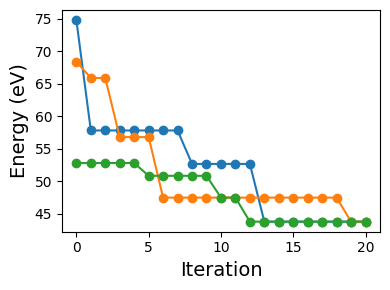

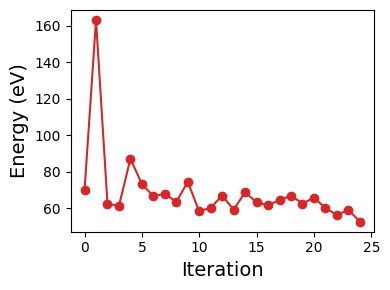

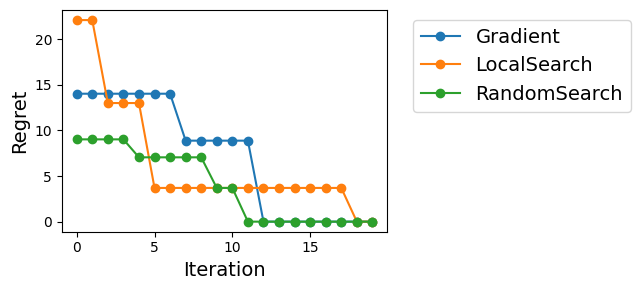

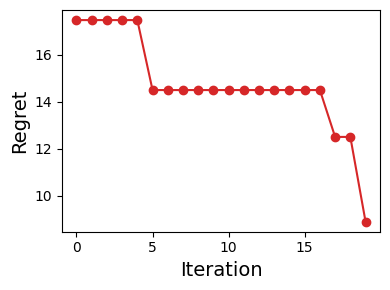

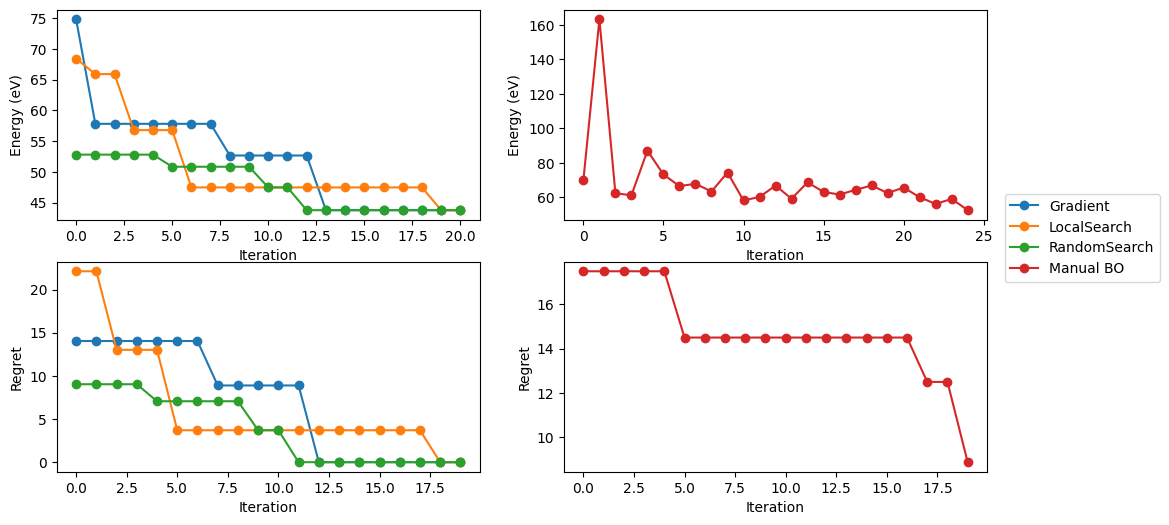

In [66]:
def plot_bo_grid(data_list, title_prefix, ylabel):
    nrows, ncols = 2, 2  # Grid layout
    plt.figure(figsize=(12, 10))

    for i, data in enumerate(data_list):

        if i==0:
            optimizer = "GradientAcquisitionOptimizer"
        elif i==1:
            optimizer = "LocalSearchAcquisitionOptimizer"
        elif i==2:
            optimizer = "RandomSearchAcquisitionOptimizer"
        else:
            optimizer = "Manual BO w/ No Optimizer"

        # Reshape or squeeze the data to be 1D if necessary
        if np.array(data).ndim > 1:
            data_array = np.array(data).squeeze()
        else:
            data_array = np.array(data).flatten()

        ax = plt.subplot(nrows, ncols, i + 1)
        # Plot the data
        if 'Energies' in title_prefix:
            color = 'blue'
            label = 'Observed Energy'
        else:
            color = 'red'
            label = 'Regret'

        ax.plot(range(len(data_array)), data_array, marker='o', color=color, label=label)
        ax.set_title(f"{title_prefix} for {optimizer}")
        ax.set_xlabel("Iteration")
        ax.set_ylabel(ylabel)
        ax.set_xticks(range(0, len(data_array), 2))  # Adjust tick step as needed
        ax.grid(True)  # Add grid background
        ax.legend()    # Add legend

    plt.tight_layout()
    plt.show()

all_observed_energies[0] = np.array(all_observed_energies[0]).ravel()
all_observed_energies[1] = np.array(all_observed_energies[1]).ravel()
all_observed_energies[2] = np.array(all_observed_energies[2]).ravel()
all_observed_energies[3] = np.array(all_observed_energies[3]).ravel()
plt.figure(figsize=(4, 3))
plt.plot(range(len(all_observed_energies[0])), all_observed_energies[0], marker='o', linestyle='-', label='Gradient')
plt.plot(range(len(all_observed_energies[1])), all_observed_energies[1], marker='o', linestyle='-', label='LocalSearch')
plt.plot(range(len(all_observed_energies[2])), all_observed_energies[2], marker='o', linestyle='-', label='RandomSearch')
#plt.yscale('log')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Energy (eV)', fontsize=14)
#plt.title('Observed Energies per Iteration')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('observed_energies.pdf', bbox_inches='tight')

plt.figure(figsize=(4, 3))
plt.plot(range(len(all_observed_energies[3])), all_observed_energies[3], marker='o', linestyle='-', label='Manual BO', c='tab:red')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Energy (eV)', fontsize=14)
plt.tight_layout()
plt.savefig('manual_bo_energy.pdf', bbox_inches='tight')




all_regrets[0] = np.array(all_regrets[0]).ravel()
all_regrets[1] = np.array(all_regrets[1]).ravel()
all_regrets[2] = np.array(all_regrets[2]).ravel()
all_regrets[3] = np.array(all_regrets[3]).ravel()
#all_regrets[3] = [all_regrets[3] for i in range(len(all_regrets[1]))]

plt.figure(figsize=(6.6, 3))
plt.plot(range(len(all_regrets[0])), all_regrets[0], marker='o', linestyle='-', label='Gradient')
plt.plot(range(len(all_regrets[1])), all_regrets[1], marker='o', linestyle='-', label='LocalSearch')
plt.plot(range(len(all_regrets[2])), all_regrets[2], marker='o', linestyle='-', label='RandomSearch')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Regret', fontsize=14)
#plt.title('Regrets per Iteration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.tight_layout()
plt.savefig('observed_regrets.pdf', bbox_inches='tight')


plt.figure(figsize=(4, 3))
plt.plot(range(len(all_regrets[3][0:20])), all_regrets[3][0:20], marker='o', linestyle='-', label='Manual BO', c='tab:red')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Regret', fontsize=14)
plt.tight_layout()
plt.savefig('manual_bo_regrets.pdf', bbox_inches='tight')


#print(all_regrets[2])
# Plotting the results
#plot_bo_grid(all_observed_energies, "Energies", "Energy")
#plot_bo_grid(all_regrets, "Regrets", "Regret")

# Plotting the figures in a grid and sharing a single legend
fig, axs = plt.subplots(2, 2, figsize=(12, 6))  # 2x2 grid

# First plot (Top-Left)
axs[0, 0].plot(range(len(all_observed_energies[0])), all_observed_energies[0], marker='o', linestyle='-', label='Gradient')
axs[0, 0].plot(range(len(all_observed_energies[1])), all_observed_energies[1], marker='o', linestyle='-', label='LocalSearch')
axs[0, 0].plot(range(len(all_observed_energies[2])), all_observed_energies[2], marker='o', linestyle='-', label='RandomSearch')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Energy (eV)')

# Second plot (Top-Right)
axs[0, 1].plot(range(len(all_observed_energies[3])), all_observed_energies[3], marker='o', linestyle='-', label='Manual BO', c='tab:red')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Energy (eV)')

# Third plot (Bottom-Left)
axs[1, 0].plot(range(len(all_regrets[0])), all_regrets[0], marker='o', linestyle='-')
axs[1, 0].plot(range(len(all_regrets[1])), all_regrets[1], marker='o', linestyle='-')
axs[1, 0].plot(range(len(all_regrets[2])), all_regrets[2], marker='o', linestyle='-')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Regret')

# Fourth plot (Bottom-Right)
axs[1, 1].plot(range(len(all_regrets[3][0:20])), all_regrets[3][0:20], marker='o', linestyle='-', c='tab:red')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Regret')

# Adding a legend outside of the plots
fig.legend(loc='center right', bbox_to_anchor=(1.05, 0.5))
# plt.savefig('all.pdf', bbox_inches='tight')

In [67]:
from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

In [68]:
# Define the kernels
constant_kernel = GPy.kern.Bias(1, variance=1.0)  # Equivalent to ConstantKernel
rbf_kernel = GPy.kern.RBF(input_dim=1, variance=10, lengthscale=1.0)  # RBF kernel
white_kernel = GPy.kern.White(1, variance=0.01)  # Equivalent to WhiteKernel

# Combine the kernels
combined_kernel = constant_kernel + rbf_kernel + white_kernel

model_gpy = GPRegression(X_train, y_train, kernel=combined_kernel)
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

In [69]:
# Use Monte Carlo-based Sobol Sensitivity Analysis
num_mc_points = 1000000  # Number of Monte Carlo points, adjust as needed
sensitivity = MonteCarloSensitivity(model=model_emukit.model, input_domain=continuous_parameter_space)
main_effects, total_effects, _ = sensitivity.compute_effects(num_monte_carlo_points=num_mc_points)

# main_effects and total_effects are dictionaries with parameter names as keys

# Example: Print the main effect of each parameter
for param_name in main_effects:
    print(f"Main effect of {param_name}: {main_effects[param_name]}")
    print(f"Total effect of {param_name}: {total_effects[param_name]}\n")

Main effect of param_0: [1.0000088]
Total effect of param_0: [1.00026803]

Main effect of param_1: [-0.00026803]
Total effect of param_1: [0.00064406]

Main effect of param_2: [-0.00026803]
Total effect of param_2: [0.00064406]

Main effect of param_3: [-0.00026803]
Total effect of param_3: [0.00064406]

Main effect of param_4: [-0.00026803]
Total effect of param_4: [0.00064406]

Main effect of param_5: [-0.00026803]
Total effect of param_5: [0.00064406]

Main effect of param_6: [-0.00026803]
Total effect of param_6: [0.00064406]

Main effect of param_7: [-0.00026803]
Total effect of param_7: [0.00064406]

Main effect of param_8: [-0.00026803]
Total effect of param_8: [0.00064406]

Main effect of param_9: [-0.00026803]
Total effect of param_9: [0.00064406]

Main effect of param_10: [-0.00026803]
Total effect of param_10: [0.00064406]

Main effect of param_11: [-0.00026803]
Total effect of param_11: [0.00064406]

Main effect of param_12: [-0.00026803]
Total effect of param_12: [0.000644